## Task
Explore the time series of subs and their types (injury vs. tactical) per match.
+ on-ball value per player comparing the one that went out and came in
+ Explore match status at the sub moment

In [2]:
import pandas as pd
import json
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')

In [3]:
match_files = ["data/event/ManCity_Arsenal_events.json", "data/event/ManCity_AstonVilla_events.json",
               "data/event/ManCity_Brighton_events.json", "data/event/ManCity_LeicesterCity_events.json",
               "data/event/ManCity_Liverpool_events.json", "data/event/ManCity_Tottenham_events.json"               
               ]

In [4]:
def calc_status(match_status, team_name):
    for key in match_status:
        if key!=team_name:
            otherTeam_name = key

    if match_status[team_name] > match_status[otherTeam_name]:
        return "win", match_status[team_name], match_status[otherTeam_name]
    elif match_status[team_name] < match_status[otherTeam_name]:
        return "lose", match_status[team_name], match_status[otherTeam_name]
    else:
        return "draw", match_status[team_name], match_status[otherTeam_name]

dics = []
mancity_name = "Manchester City WFC"

scores = []
all_players = []
for match in match_files:
    lineup_file = "data/event/" + "_".join(match.split("/")[-1].split(".")[0].split("_")[:-1]) + "_lineups.json"
    match_name = " vs. ".join(match.split("/")[-1].split(".")[0].split("_")[:-1])
    players = {}
    
    match_status = {}
    with open(lineup_file) as l:
        lineups = json.load(l)
        for lineup in lineups:
            match_status[lineup["team_name"]] = 0
            for player in lineup["lineup"]:
                team2player = {}
                team2player["match_name"] = match_name
                team2player["team_name"] = lineup["team_name"]
                team2player["player_name"] = player["player_name"]
                all_players.append(team2player)
                for position in player["positions"]:
                    if position["start_reason"].startswith("Substitution"):
                        players[player["player_name"]] = position["position"]

    with open(match) as m:
        events = json.load(m)
        pre_event_sub = False

        for event in events:
            if "shot" in event:
                if event["shot"]["outcome"]["name"] == "Goal":
                    score = {}
                    score["match"] = match_name
                    score["home_team"] = mancity_name
                    for key in match_status:
                        if key!=mancity_name:
                            score["away_team"] = key
                    score["time"] = round(event['second'] / 60 +  event['minute'], 2)
                    score["home_score"] = match_status[score["home_team"]]
                    score["opp_score"] = match_status[score["away_team"]]
                    scores.append(score)
                    match_status[event["team"]["name"]]+=1

            if event["type"]["name"]=="Substitution":
                dic = {}
                dic["match"] = match_name
                dic["team"] = event["team"]["name"]
                dic["player_out"] = event["player"]["name"]
                dic["player_out_position"] = event["position"]["name"]
                dic["player_in"] = event["substitution"]["replacement"]["name"]
                # if dic["team"] == mancity_name:
                dic["player_in_position"] = players[dic["player_in"]]
                dic["reason"] = event["substitution"]["outcome"]["name"]
                dic["time"] = round(event['second'] / 60 +  event['minute'], 2)
                dic["match_status"], dic["team_score"], dic["opp_score"] = calc_status(match_status, dic["team"])
                dic["formation_change"] = "No"
                dics.append(dic)
                pre_event_sub=True
            elif pre_event_sub:
                dic = dics.pop()
                if "tactics" in event:
                    dic["formation_change"] = "Yes"                    
                pre_event_sub=False
                dics.append(dic)

all_players_df = pd.DataFrame(all_players).drop_duplicates()
all_players_df.to_csv("all_players.csv", index=False)
display(all_players_df.head())

df = pd.DataFrame(dics)
df.to_csv("all_subs.csv", index=False)
display(df.head())

scores_df = pd.DataFrame(scores)
scores_df.to_csv("scores.csv", index=False)
display(scores_df.head())

,match_name,team_name,player_name
0,ManCity vs. Arsenal,Manchester City WFC,Ellie Roebuck
1,ManCity vs. Arsenal,Manchester City WFC,Hayley Emma Raso
2,ManCity vs. Arsenal,Manchester City WFC,Leila Ouahabi El Ouahabi
3,ManCity vs. Arsenal,Manchester City WFC,Stephanie Houghton
4,ManCity vs. Arsenal,Manchester City WFC,Alex Greenwood


,match,team,player_out,player_out_position,player_in,player_in_position,reason,time,match_status,team_score,opp_score,formation_change
0,ManCity vs. Arsenal,Arsenal WFC,Caitlin Jade Foord,Left Wing,Katie McCabe,Left Wing,Tactical,45.00,lose,0,2,No
1,ManCity vs. Arsenal,Arsenal WFC,Carlotte Wubben-Moy,Center Back,Lia Wälti,Center Back,Tactical,45.00,lose,0,2,Yes
2,ManCity vs. Arsenal,Arsenal WFC,Victoria Pelova,Left Midfield,Kathrine Møller Kühl,Left Midfield,Tactical,67.97,lose,1,2,No
3,ManCity vs. Arsenal,Arsenal WFC,Noelle Maritz,Right Back,Laura Wienroither,Right Back,Tactical,80.10,lose,1,2,No
4,ManCity vs. Arsenal,Arsenal WFC,Emma Stina Blackstenius,Right Center Forward,Giovana Queiroz Costa,Right Center Forward,Tactical,80.32,lose,1,2,No


,match,home_team,away_team,time,home_score,opp_score
0,ManCity vs. Arsenal,Manchester City WFC,Arsenal WFC,3.08,0,0
1,ManCity vs. Arsenal,Manchester City WFC,Arsenal WFC,42.57,1,0
2,ManCity vs. Arsenal,Manchester City WFC,Arsenal WFC,58.17,2,0
3,ManCity vs. AstonVilla,Manchester City WFC,Aston Villa,27.78,0,0
4,ManCity vs. AstonVilla,Manchester City WFC,Aston Villa,30.15,1,0


In [5]:
df.columns

Index(['match', 'team', 'player_out', 'player_out_position', 'player_in',
       'player_in_position', 'reason', 'time', 'match_status', 'team_score',
       'opp_score', 'formation_change'],
      dtype='object')

## Sub Time Analysis

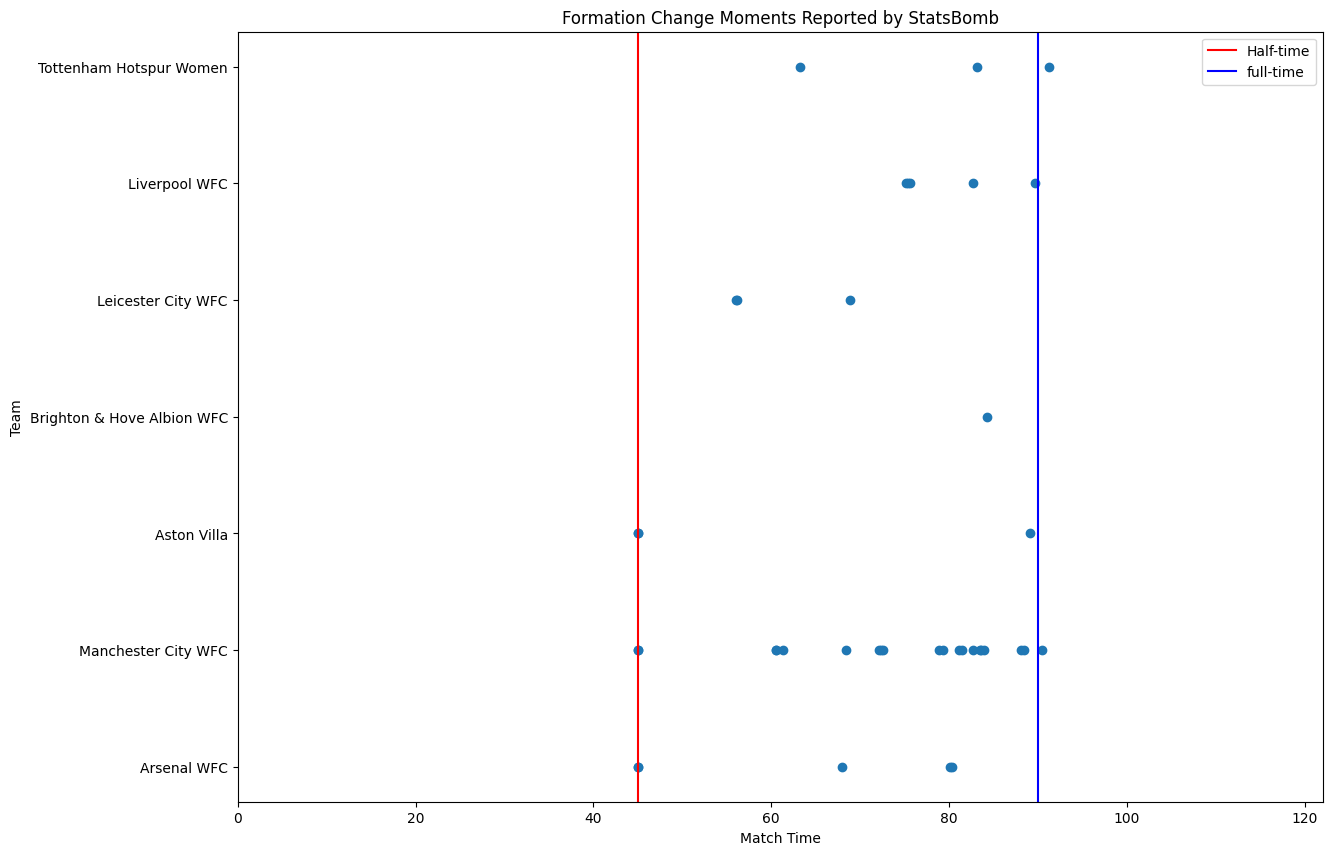

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))
plt.xlim(0, 122)
plt.axvline(x = 45, color = 'r', label = 'Half-time')
plt.axvline(x = 90, color = 'b', label = 'full-time')
plt.scatter(df.time, df.team)
plt.title("Formation Change Moments Reported by StatsBomb")
plt.xlabel("Match Time")
plt.ylabel("Team")
plt.legend();

In [7]:
mancity_df = df[df["team"]=="Manchester City WFC"]

print(f"Number of Man City Subs were {mancity_df.shape[0]} in 6 matches")

Number of Man City Subs were 20 in 6 matches


## Sub HeatMap

### Position

In [8]:
groups = mancity_df.groupby(["player_out_position","player_in_position"]).size().reset_index(name="count")
groups

,player_out_position,player_in_position,count
0,Center Forward,Center Forward,2
1,Left Back,Left Back,1
2,Left Center Back,Left Center Back,1
3,Left Center Midfield,Left Center Midfield,2
4,Left Wing,Left Wing,2
5,Right Back,Right Back,2
6,Right Center Back,Right Center Back,2
7,Right Center Midfield,Right Center Midfield,3
8,Right Midfield,Right Midfield,1
9,Right Wing,Right Wing,4


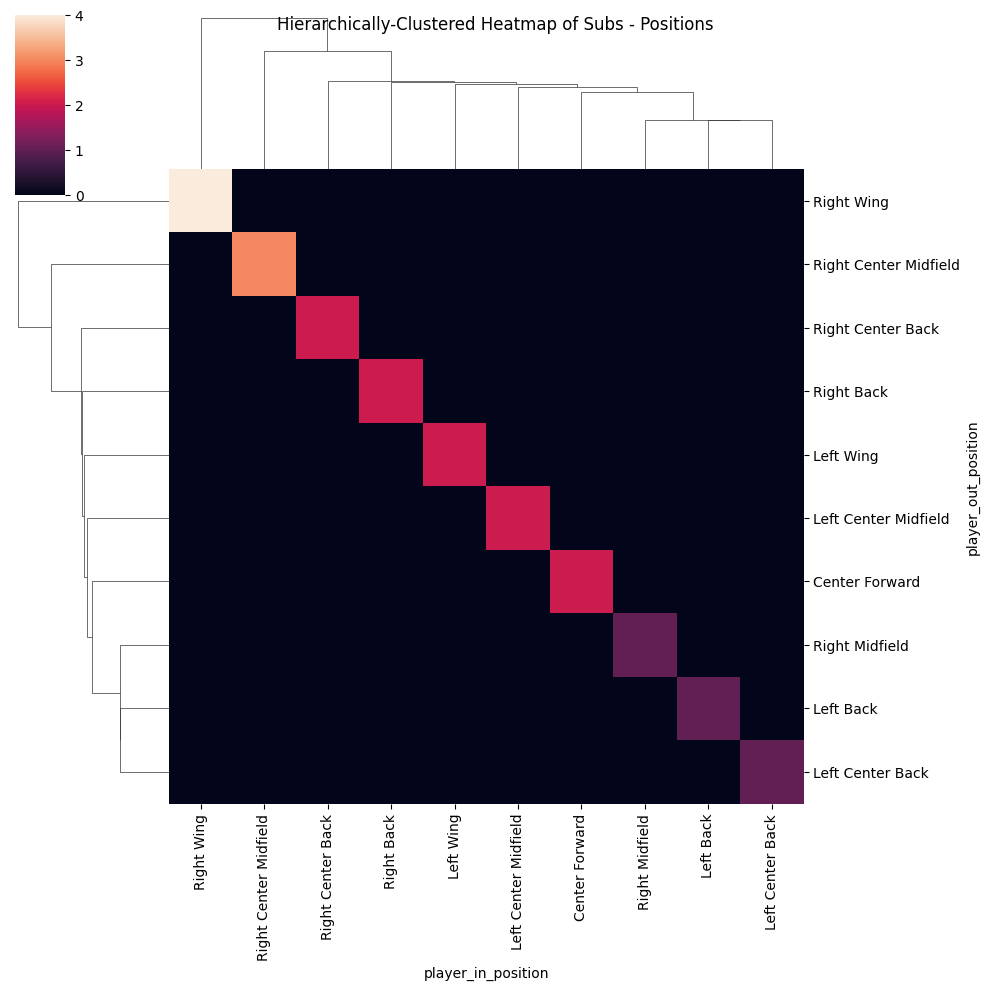

In [9]:
heatmap_df = groups.pivot_table(index='player_out_position', columns='player_in_position', values="count", fill_value=0)

g = sns.clustermap(heatmap_df)
g.fig.suptitle('Hierarchically-Clustered Heatmap of Subs - Positions');

### Players

In [10]:
groups = mancity_df.groupby(["player_out","player_in"]).size().reset_index(name="count")
groups

,player_out,player_in,count
0,Alex Greenwood,Stephanie Houghton,1
1,Chloe Kelly,Hayley Emma Raso,5
2,Deyna Cristina Castellanos Naujenis,Ingrid Filippa Angeldal,2
3,Deyna Cristina Castellanos Naujenis,Ruby Mace,1
4,Esme Beth Morgan,Kerstin Yasmijn Casparij,1
5,Kerstin Yasmijn Casparij,Esme Beth Morgan,1
6,Khadija Monifa Shaw,Mary Boio Fowler,2
7,Laia Aleixandri López,Leila Ouahabi El Ouahabi,1
8,Laura Coombs,Deyna Cristina Castellanos Naujenis,1
9,Laura Coombs,Ingrid Filippa Angeldal,1


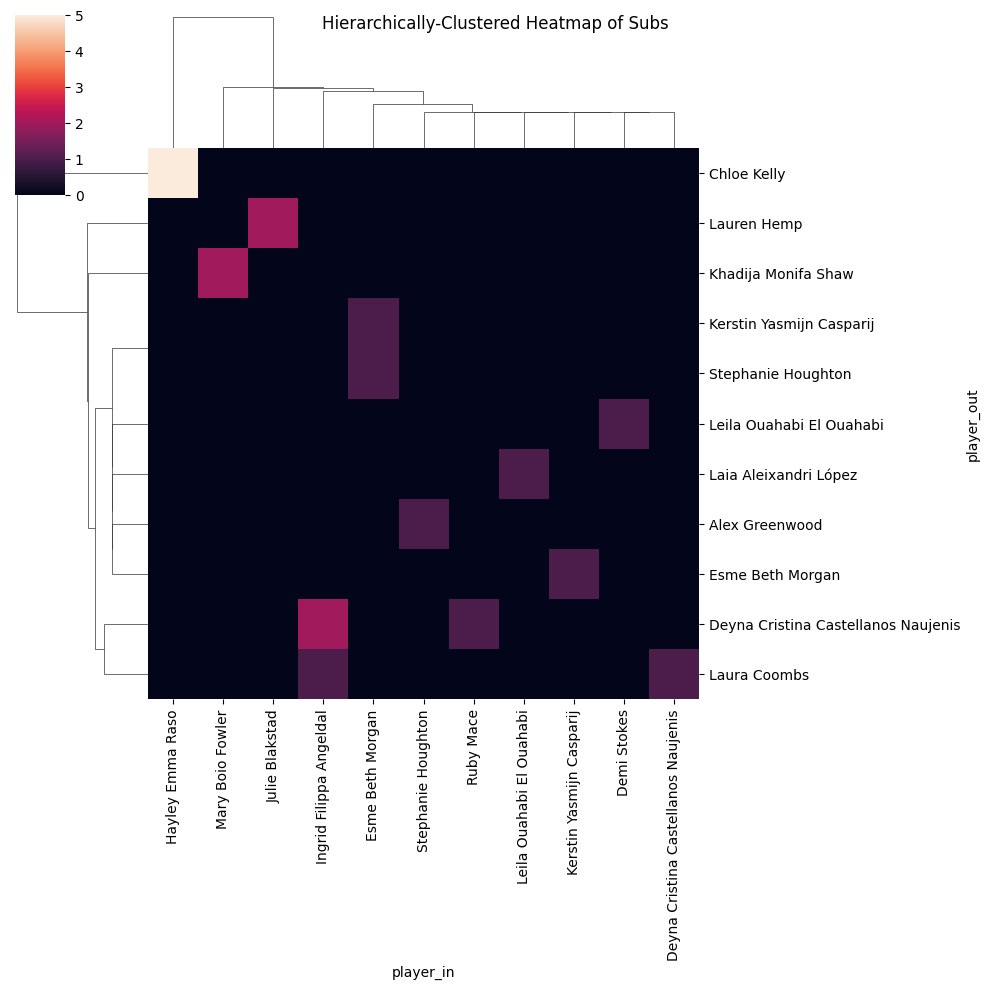

In [11]:
heatmap_df = groups.pivot_table(index='player_out', columns='player_in', values="count", fill_value=0)

g = sns.clustermap(heatmap_df)
g.fig.suptitle('Hierarchically-Clustered Heatmap of Subs');
# g.fig.set_figwidth(20)
# g.fig.set_figheight(20)
# plt.tight_layout()
# g.fig.savefig("out.png") 